NOTEBOOK INI BERACUAN PADA URL DIBAWAH INI

https://python.langchain.com/docs/tutorials/rag/#setup

Install package yang diperlukan

In [1]:
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


karna ini di notebook, jadi pemanggilan keys bisa di attach secara local di notebook ini menggunakan kode dibawah ini

In [24]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

install package langchain-openai karna menggunakan model dari openai yaitu gpt-4o-mini

In [4]:
pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


untuk bisa menggunakan model diperlukan API KEY dari openai, pastikan credit terisi, API berbayar ni, semua butuh duit cuy

In [25]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

import juga embeddingnya, biar komputer bisa ngerti, terjemahin dari vector

In [5]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [6]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


vector disimpan di dalam memory, jadi gapake database luar kaya chromadb dll

In [9]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

sebelum mulai nanyain llm nya, kasih konteks dulu, dokumen/informasi apa yg mau dipelajari sama modelnya

di bawah ini kita nyiapin informasi dari link website sebagai konten untuk model belajar

In [41]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


Dibawah ini coba ngeload pdf

ngtes print dokumen yang siap di pelajari oleh model

In [15]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


karna informasi yang ada di link itu banyak banget (40rban karakter), maka informasi dipisah menggunakan kode dibawah ini.

pemisahan dilakukan menjadi chunk yang saling overlapping, biar informasi masih saling konek dan model ga kesulitan nyari informasi kalo jadi satu chunck doang.

metode yg digunakan untuk pemisahan chunck ini adalah RecursiveCharacterTextSplitter

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


setelah dokumennya di split jadi chunck yang banyak, waktunya di store ke vector, nanti bisa dilakukan pencarian menggunakan 'vector search'

In [17]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['ca845224-de59-4aff-a3dc-690634a8b3b7', 'c19c4325-ee62-4848-9fe3-96d6c8ed0876', 'b34a31a3-7057-44e9-ae3e-be0504a71c36']


dibawah ini bisa diatur prompt yang akan menjadi template interaksi kita sama model

In [18]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


katanya untuk manyatukan step
retrival dan generation
digunakan yg namanya langgraph, banyak keunggulannya, walaupun ga wajib

buat make langgraph diperlukan 3 hal
1. state dari aplikasi
2. setiap nodes aplikasi
3. control flow dari aplikasi

berikut penjelasannya

State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

In [19]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Nodes (application steps)
Let's start with a simple sequence of two steps: retrieval and generation.

In [20]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Control flow
Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [21]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

nanti bisa ketauan flow dari aplikasi kita kaya gimana menggunakan kode dibawah ini

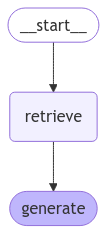

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

TESTING APP!!

In [31]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b34a31a3-7057-44e9-ae3e-be0504a71c36', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='e80bfb0c-e07b-4054-b2d3-7f28910efd14', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent

In [27]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='b34a31a3-7057-44e9-ae3e-be0504a71c36', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='e80bfb0c-e07b-4054-b2d3-7f28910efd14', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sy

In [28]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps|,| which| can| be| facilitated| by| techniques| like| Chain| of| Thought| (|Co|T|).| This| approach| allows| a| model| to| think| step|-by|-step|,| enhancing| its| performance| on| difficult| tasks| and| providing| clarity| on| the| reasoning| process|.| It| can| involve| prompts|,| task|-specific| instructions|,| or| human| inputs| to| identify| sub|go|als| and| outline| steps| for| achieving| the| overall| task|.||

prompt juga bisa di kostumisasi seperti di bawah ini

In [32]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [36]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}